In [7]:
# ===================================================================
# ЭТАП 4 (ИСПРАВЛЕННЫЙ): Симуляция и формирование рекомендаций
# ===================================================================

print("--- Начало Исправленного Этапа 4 ---")

# Импорт всех необходимых библиотек
import pandas as pd
import numpy as np
import lightgbm as lgb
import os
import seaborn as sns
import matplotlib.pyplot as plt

# --- Шаг 4.1: Загрузка финальных "честных" артефактов ---
data_dir = 'processed_data'
model_dir = 'models'
# ВАЖНО: Убедитесь, что здесь лежит модель, обученная БЕЗ 'rating' и 'reviewCount'
model_path = os.path.join(model_dir, 'lgbm_model.txt') 

try:
    # Загружаем модель
    final_model = lgb.Booster(model_file=model_path)
    # Загружаем вспомогательные данные
    city_stats = pd.read_csv(os.path.join(data_dir, 'city_stats.csv'))
    # Загружаем X_train, чтобы знать точный порядок и названия колонок для новой модели
    X_train_columns = pd.read_csv(os.path.join(data_dir, 'X_train.csv')).columns
    
    # --- ИСПРАВЛЕНИЕ: Убираем 'leaky' признаки из списка колонок, если они там остались ---
    features_to_drop = ['rating', 'reviewCount']
    X_train_columns = [col for col in X_train_columns if col not in features_to_drop]
    
    print("✅ Финальная модель и вспомогательные данные успешно загружены.")
except Exception as e:
    print(f"❌ Ошибка при загрузке артефактов: {e}")

--- Начало Исправленного Этапа 4 ---
✅ Финальная модель и вспомогательные данные успешно загружены.


In [8]:
# --- Шаг 4.2: Определение сценариев и проведение "честной" симуляции ---

# Выбираем города и типы авто для теста (здесь ничего не меняется)
top_cities = city_stats.sort_values(by='city_car_count', ascending=False).head(30)['location.city'].tolist()
vehicle_types_to_test = ['car', 'suv', 'truck', 'van']

# --- ИСПРАВЛЕНИЕ: Убираем 'leaky' признаки из параметров симуляции ---
virtual_car_params = {
    'vehicle.age': 1,
    'fuelType_GASOLINE': True, 'fuelType_HYBRID': False, 'fuelType_ELECTRIC': False
}

print("Начинаем симуляцию на основе 'честной' модели...")
simulation_results = []

for city in top_cities:
    for v_type in vehicle_types_to_test:
        current_city_stats = city_stats[city_stats['location.city'] == city]
        if current_city_stats.empty: continue

        # --- ИСПРАВЛЕНИЕ: Словарь признаков теперь не содержит 'rating' и 'reviewCount' ---
        features_dict = {
            'vehicle.age': virtual_car_params['vehicle.age'],
            'rate.daily': current_city_stats['city_avg_rate'].iloc[0],
            'city_avg_trips': current_city_stats['city_avg_trips'].iloc[0],
            'city_car_count': current_city_stats['city_car_count'].iloc[0] + 1,
            'city_avg_rate': current_city_stats['city_avg_rate'].iloc[0],
            'state_avg_trips': 0, 'state_car_count': 0, # Упрощение
            'vehicle.type_suv': v_type == 'suv',
            'vehicle.type_truck': v_type == 'truck',
            'vehicle.type_van': v_type == 'van',
            'fuelType_GASOLINE': virtual_car_params['fuelType_GASOLINE'],
            'fuelType_HYBRID': virtual_car_params['fuelType_HYBRID'],
            'fuelType_ELECTRIC': virtual_car_params['fuelType_ELECTRIC'],
        }
        
        scenario_info = {'city': city, 'vehicle_type': v_type}
        scenario_info.update(features_dict)
        simulation_results.append(scenario_info)

simulation_df = pd.DataFrame(simulation_results)

# Создаем финальный DataFrame для модели с правильными колонками
final_simulation_df = pd.DataFrame(columns=X_train_columns)
for col in X_train_columns:
    if col in simulation_df.columns:
        final_simulation_df[col] = simulation_df[col]
    else:
        # Заполняем недостающие One-Hot колонки (например, 'vehicle.type_minivan')
        final_simulation_df[col] = False

# Получаем предсказания от НАСТРОЕННОЙ "ЧЕСТНОЙ" модели
predicted_trips = final_model.predict(final_simulation_df)
simulation_df['predicted_trips'] = predicted_trips

print("✅ Симуляция завершена.")

Начинаем симуляцию на основе 'честной' модели...
✅ Симуляция завершена.



🏆 Топ-20 самых перспективных направлений (на основе 'честной' модели):


,city,vehicle_type,predicted_trips,rate.daily
72,Jersey City,car,36.22,151.56
75,Jersey City,van,33.54,151.56
108,Philadelphia,car,29.58,80.42
73,Jersey City,suv,29.20,151.56
111,Philadelphia,van,26.66,80.42
74,Jersey City,truck,26.07,151.56
109,Philadelphia,suv,23.42,80.42
76,Phoenix,car,21.44,68.98
28,Los Angeles,car,19.98,129.07
110,Philadelphia,truck,18.70,80.42


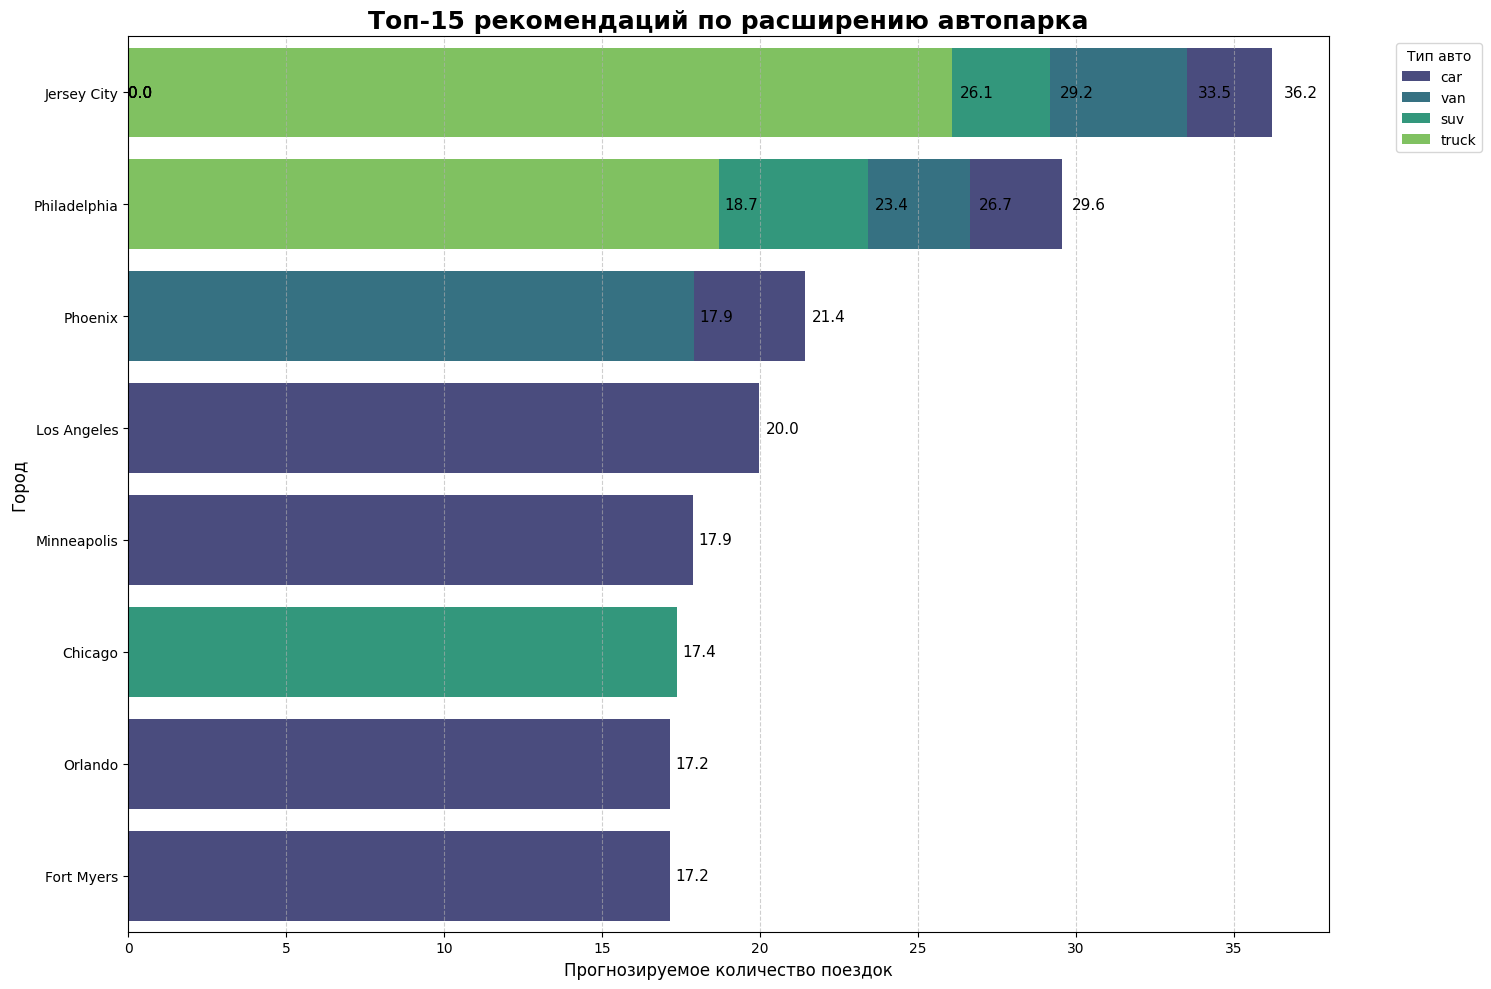


### Итоговые бизнес-рекомендации ###
1. **Приоритетное направление:** Наиболее выгодным вложением является добавление автомобилей типа 'CAR' в городе **Jersey City**. Прогнозируемый спрос составляет **36.2** поездок на один новый автомобиль.

2. **Диверсификация:** Города, такие как Jersey City, Philadelphia и Jersey City, также показывают высокий потенциал для разных типов автомобилей, что подтверждает наши гипотезы из EDA.

3. **Инструмент для принятия решений:** Разработано интерактивное приложение (Streamlit), позволяющее менеджерам самостоятельно оценивать потенциал любого города и типа автомобиля в режиме реального времени.


In [9]:
# --- Шаг 4.3: Анализ РЕАЛИСТИЧНЫХ результатов и формирование рекомендаций ---

top_recommendations = simulation_df.sort_values(by='predicted_trips', ascending=False)

print("\n🏆 Топ-20 самых перспективных направлений (на основе 'честной' модели):")
display(top_recommendations[['city', 'vehicle_type', 'predicted_trips', 'rate.daily']].head(20).round(2))

# --- Визуализация для презентации ---
top_15_df = top_recommendations.head(15)

plt.figure(figsize=(15, 10))
ax = sns.barplot(data=top_15_df, y='city', x='predicted_trips', hue='vehicle_type', dodge=False, palette='viridis', orient='h')

# --- ИСПРАВЛЕНИЕ: Улучшенный код для добавления меток на график ---
for p in ax.patches:
    width = p.get_width()
    # Позиционируем текст немного правее конца бара
    ax.text(width * 1.01, p.get_y() + p.get_height() / 2.,
             f'{width:.1f}', va='center', fontsize=11)

plt.title('Топ-15 рекомендаций по расширению автопарка', fontsize=18, weight='bold')
plt.xlabel('Прогнозируемое количество поездок', fontsize=12)
plt.ylabel('Город', fontsize=12)
plt.legend(title='Тип авто', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Формулировка бизнес-выводов для презентации ---
print("\n### Итоговые бизнес-рекомендации ###")
top_choice = top_recommendations.iloc[0]
print(f"1. **Приоритетное направление:** Наиболее выгодным вложением является добавление автомобилей типа '{top_choice['vehicle_type'].upper()}' в городе **{top_choice['city']}**. Прогнозируемый спрос составляет **{top_choice['predicted_trips']:.1f}** поездок на один новый автомобиль.")
print("\n2. **Диверсификация:** Города, такие как {c1}, {c2} и {c3}, также показывают высокий потенциал для разных типов автомобилей, что подтверждает наши гипотезы из EDA.".format(
    c1=top_recommendations.iloc[1]['city'],
    c2=top_recommendations.iloc[2]['city'],
    c3=top_recommendations.iloc[3]['city']
))
print("\n3. **Инструмент для принятия решений:** Разработано интерактивное приложение (Streamlit), позволяющее менеджерам самостоятельно оценивать потенциал любого города и типа автомобиля в режиме реального времени.")